## Obligatorio de Deep Learning - Semestre 2 - 2022

## 1. Setup

### 1.1 Imports

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [2]:
import subprocess
try:
    subprocess.call(['cd', '/content/drive/MyDrive/ORT/DeepLearning/Obligatorio/'],shell=True)
except:
    pass


In [4]:
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from importlib import reload
import utils
utils = reload(utils)

ModuleNotFoundError: No module named 'tensorflow'

### 1.2 Set random seeds

In [44]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [45]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [46]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [47]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### 3.1 Análisis descriptivo general: Distribuciones, Scatterplots, Barplots...

In [48]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


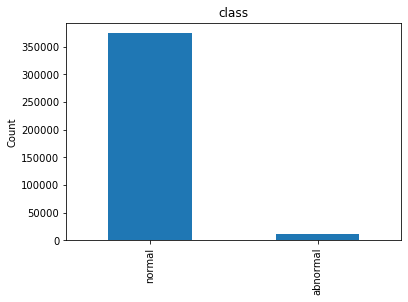

In [49]:
utils.value_counts(hdfs_train,'class')

### 3.2 Análisis de secuencias

In [50]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [51]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)
#raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
try:
    data_y.value_counts()
except:
    pass

In [53]:
min([min(s) for s in raw_sequences])

1

In [54]:
max([max(s) for s in raw_sequences])

28

In [55]:
vocab_size = max([max(s) for s in raw_sequences]) + 1

In [56]:
max([len(s) for s in raw_sequences])

298

#### El valor de vocab_size es importante ya que es la dimensionalidad del lenguaje

#### Definiremos arbitrariamente el largo máximo de secuencias (es este tamaño razonable?)

In [57]:
max_len = 30

#### Haremos padding de valor 0 a las secuencias para estandarizar el largo

In [58]:
padded_sequences = utils.pad_sequences(raw_sequences, max_len)

## 4. Entrenamiento de Language Model

### 4.1. Data preprocessing
#### 4.1.1 Particionamiento

In [59]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

#### 4.1.2 X_train_aug (para data augmentation)

In [ ]:
X_train_for_aug, _, _, _, _, _ = utils.split(raw_sequences, data_y)

In [ ]:
X_train_aug, y_train_aug = sequences_augmentation(X_train_for_aug, y_train, max_len)

### 4.2 RNN

In [61]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5
loss = 'categorical_crossentropy'
import math
embedding_size = math.ceil(vocab_size**0.25) #es un hiperparametro. cuanto mas grande, mayor el entrenamiento

In [62]:
name='ClipNorm_BatchNormalization_Doble_LSTM_7epochs_40ml'

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 3)             90        
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            17408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 50,908
Trainable params: 50,780
Non-trainable params: 128
_________________________________________________________________


### 4.3 Entrenamiento

#### 4.3.1 Hiperarámetros

In [63]:
batch_size = 10
epochs = 7
patience = 10

In [64]:
#se agregó class.weights
training1, model1 = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
26007/26007 [==============================] - 281s 11ms/step - loss: 0.0366 - accuracy: 0.9978 - val_loss: 0.0080 - val_accuracy: 0.9994
Epoch 2/7
26007/26007 [==============================] - 278s 11ms/step - loss: 0.0224 - accuracy: 0.9992 - val_loss: 0.0686 - val_accuracy: 0.9992
Epoch 3/7
26007/26007 [==============================] - 274s 11ms/step - loss: 0.0228 - accuracy: 0.9993 - val_loss: 1.3288 - val_accuracy: 0.0665
Epoch 4/7
26007/26007 [==============================] - 278s 11ms/step - loss: 0.0303 - accuracy: 0.9992 - val_loss: 0.0078 - val_accuracy: 0.9994
Epoch 5/7
26007/26007 [==============================] - 280s 11ms/step - loss: 0.0134 - accuracy: 0.9994 - val_loss: 0.0216 - val_accuracy: 0.9911
Epoch 6/7
26007/26007 [==============================] - 273s 11ms/step - loss: 0.0151 - accuracy: 0.9994 - val_loss: 0.0242 - val_accuracy: 0.9946
Epoch 7/7
26007/26007 [==============================] - 288s 11ms/step - loss: 0.0116 - accuracy: 0.9995 - val_

### 4.4 Evaluación del modelo

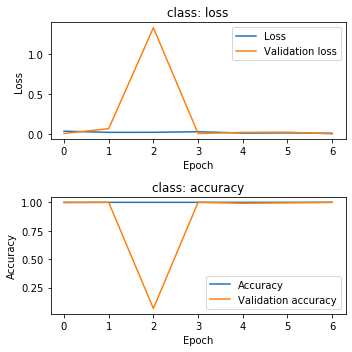

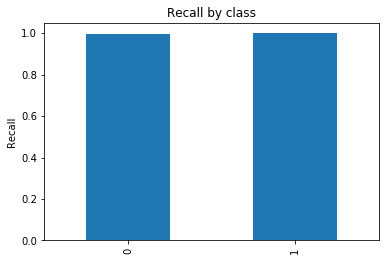

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      1.00      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.006256977561861277, accuracy: 0.99923175573349


In [65]:
utils.eval_model(training1, model1, X_test, y_test)

## 5 Generación de salida para competencia Kaggle

In [66]:
utils.load_test_sequences_and_generate_prediction_file(model1, hdfs_test_kaggle, max_len, name)

,id,expected
0,0,normal
1,1,abnormal
2,2,normal
3,3,normal
4,4,normal
...,...,...
189765,189765,normal
189766,189766,normal
189767,189767,normal
189768,189768,normal


In [67]:
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

Saved model to disk


## 6 Consigna

### A) Participación en Competencia Kaggle:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Macro Average Recall (o Weighted Accuracy) superior al 80%. [->Link a la competencia<-](https://www.kaggle.com/t/6d15e3a96bd049b2b4b2a491a69a0fc7).

### B) Utilización de Grid Search (o equivalente):
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible.

### C) Se debe a su vez investigar e implementar al menos 2 de las siguientes técnicas:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Data Augmentation a través de la realización de Windowing](https://blog.finxter.com/how-to-loop-through-a-python-list-in-batches/#Method_1_Iterating_over_Consecutive_Sliding_Windows)
#### 3. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)
